# CNN & LSTM for Sentiment Analysis

The task is to classify the BBC news data based on their sentiment

In [ ]:
!gdown 19xU3kUyivRWGQzYXnpwlIjQqdfkD56v4

Downloading...
From: https://drive.google.com/uc?id=19xU3kUyivRWGQzYXnpwlIjQqdfkD56v4
To: /content/twitter_data.csv
100% 10.3M/10.3M [00:00<00:00, 87.0MB/s]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
data = pd.read_csv('twitter_data.csv')

In [ ]:
data

,id,user,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


We have 4 types of sentiment: 'Negative', 'Positive', 'Neutral', and 'Irrelevant'.

<Axes: >

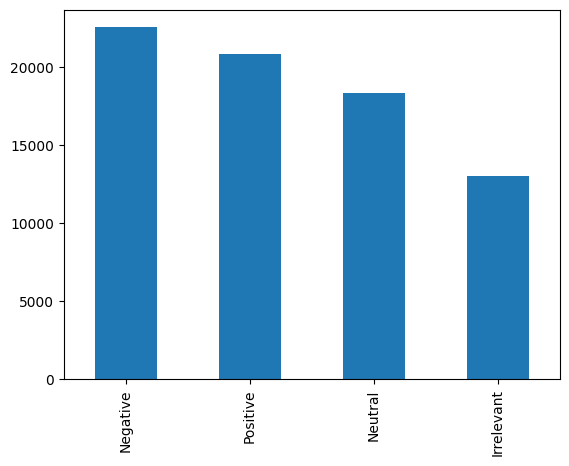

In [ ]:
data['sentiment'].value_counts().plot.bar()

In [ ]:
data.isnull().sum()

id             0
user           0
sentiment      0
tweet        686
dtype: int64

We will remove the tweets which are null since there's no way we can impute them.

In [ ]:
data = data.dropna(axis=0)

Let's check the length in characters for each tweet

In [ ]:
data['text_length'] = data['tweet'].apply(len)

<ipython-input-26-1e4f4097cd69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_length'] = data['tweet'].apply(len)


<Axes: ylabel='Frequency'>

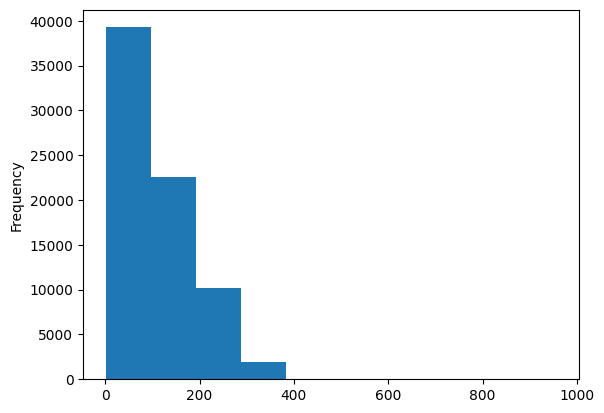

In [ ]:
data['text_length'].plot.hist()

We have a small number of outliers

In [ ]:
X = data['tweet']
Y = pd.get_dummies(data['sentiment'])

In [ ]:
Y

,Irrelevant,Negative,Neutral,Positive
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
74677,0,0,0,1
74678,0,0,0,1
74679,0,0,0,1
74680,0,0,0,1


In [ ]:
num_classes = len(Y.columns)

In [ ]:
num_classes

4

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
data['num_words'] = data['tweet'].apply(lambda x: len(x.split(" ")))

<ipython-input-38-3073e65ba786>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['num_words'] = data['tweet'].apply(lambda x: len(x.split(" ")))


<Axes: ylabel='Frequency'>

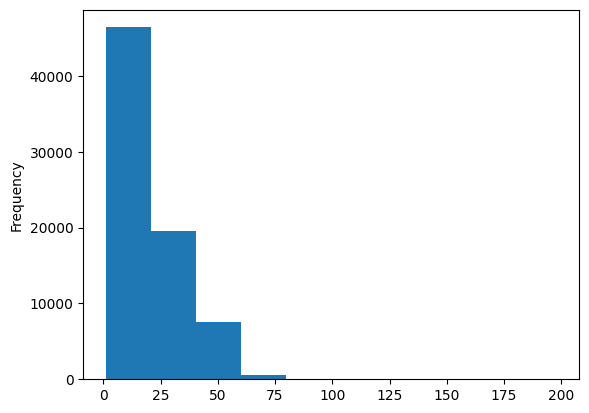

In [ ]:
data['num_words'].plot.hist()

In [ ]:
max_tokens = 64

In [ ]:
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train.values)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
len_tokens = [len(token_list) for token_list in X_train]

(array([2.5655e+04, 1.4980e+04, 8.3650e+03, 4.9540e+03, 2.8470e+03,
        1.7910e+03, 4.4000e+02, 1.2700e+02, 3.2000e+01, 5.0000e+00]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <BarContainer object of 10 artists>)

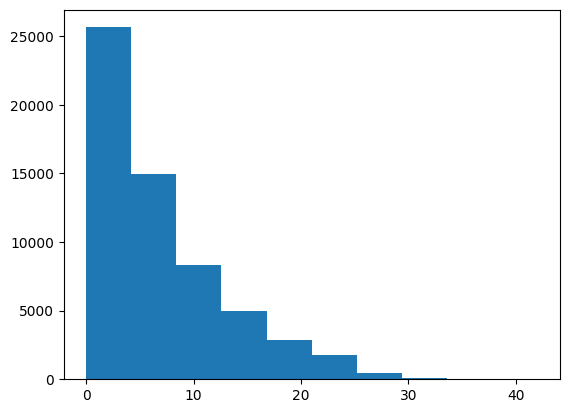

In [ ]:
plt.hist(len_tokens)

In [ ]:
maxlen=16

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
X_train.shape, X_test.shape

((59196, 16), (14800, 16))

# Create the Model

In [ ]:
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
model = Sequential()
model.add(Embedding(max_tokens, 32, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=64, epochs=10)

Epoch 1/10
740/740 [==============================] - 26s 25ms/step - loss: 1.3134 - precision_1: 0.5712 - recall_1: 0.0635 - val_loss: 1.2834 - val_precision_1: 0.6017 - val_recall_1: 0.1064
Epoch 2/10
740/740 [==============================] - 18s 25ms/step - loss: 1.2697 - precision_1: 0.6005 - recall_1: 0.1199 - val_loss: 1.2660 - val_precision_1: 0.6041 - val_recall_1: 0.1459
Epoch 3/10
740/740 [==============================] - 17s 23ms/step - loss: 1.2520 - precision_1: 0.6182 - recall_1: 0.1445 - val_loss: 1.2550 - val_precision_1: 0.6430 - val_recall_1: 0.1323
Epoch 4/10
740/740 [==============================] - 21s 28ms/step - loss: 1.2365 - precision_1: 0.6279 - recall_1: 0.1636 - val_loss: 1.2425 - val_precision_1: 0.6329 - val_recall_1: 0.1595
Epoch 5/10
740/740 [==============================] - 18s 24ms/step - loss: 1.2230 - precision_1: 0.6299 - recall_1: 0.1784 - val_loss: 1.2435 - val_precision_1: 0.5922 - val_recall_1: 0.1983
Epoch 6/10
740/740 [====================

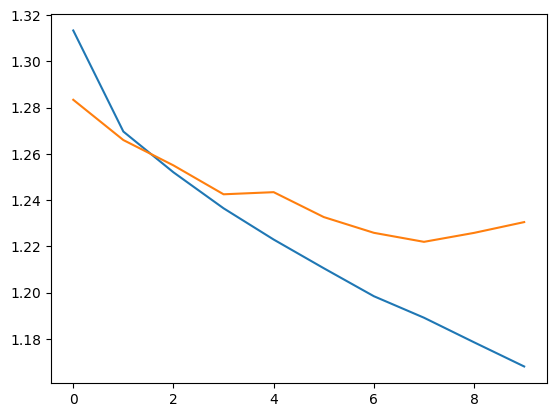

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

What does it mean?

In [ ]:
preds = model.predict(X_test)

463/463 [==============================] - 8s 15ms/step


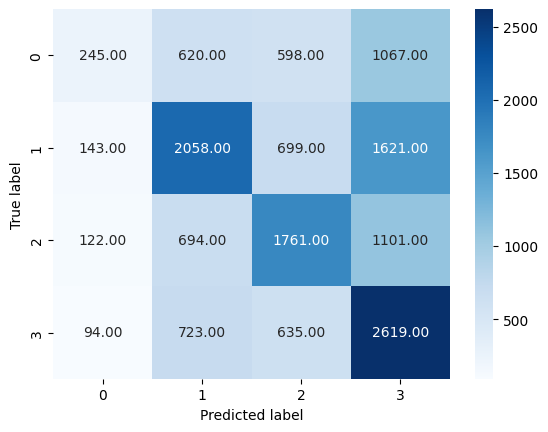

In [ ]:
confmat = confusion_matrix(np.argmax(Y_test.values, axis=1), np.argmax(preds, axis=1))
sns.heatmap(confmat, annot=True, cmap='Blues', fmt='5.2f')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print(classification_report(np.argmax(Y_test.values, axis=1), np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.41      0.10      0.16      2530
           1       0.50      0.46      0.48      4521
           2       0.48      0.48      0.48      3678
           3       0.41      0.64      0.50      4071

    accuracy                           0.45     14800
   macro avg       0.45      0.42      0.40     14800
weighted avg       0.45      0.45      0.43     14800

